In [ ]:
# Import all modules for exploratory data analysis

# Extract and save data from database
import db_utils as dbu
# Change datatype of columns to the appripriate ones
import pre_processing as prep
# Get descritve informarion from the dataframe
import extract_info as extract 
# Creates plots for data
import plot as plo
import pandas as pd
import numpy as np
from statsmodels.graphics.gofplots import qqplot
from scipy import stats
from matplotlib import pyplot
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm




In [ ]:
# Extract cloud database credentials from yaml file
db_credentials = dbu.read_credentials("/Users/ChAre/OneDrive/Desktop/aicore/EDA_finance/credentials.yaml")

# Extracting the data from Amazon RDS

In [ ]:
# Initialise RDSDatabaseConnector class
db_connector = dbu.RDSDatabaseConnector(db_credentials)

In [ ]:
# Connect to database and extract desire database in the cloud
# RDSDatabaseConnector.save_data() call upon: extract_data, 
#db_connector.save_data()

In [ ]:
# Load data into pyhton
df_unclean = db_connector.load_data("./loan_payments")

# Data preprocessing

In [ ]:
# Inspect the columns data types
df_unclean.info()

In [ ]:
# Create instance of preprocessing of DataTransform class for preprocessing.
df_prep = prep.DataTransform(df_unclean)

In [ ]:
# Transform columns into the categorical data type
df_prep.category_transform(["grade", "sub_grade", "home_ownership", "verification_status", "loan_status", "payment_plan", "purpose", "application_type", "employment_length", "policy_code", "term"])

In [ ]:
# Convert columns to date type data
df_prep.date_transform(["issue_date", "earliest_credit_line", "last_payment_date", "next_payment_date", "last_credit_pull_date"])

In [ ]:
# Preporcess term column

# Convert column values into strings
df_prep.string_transform(["term"])

# Remove unwanted characters from the column values
df_prep.remove_characters("term", ["months"])

# Transform column values to numeric
df_prep.numeric_transform(["term"])

#Rename column to reflect the unit for the values
df_prep.rename_column("term", "term_in_months")

In [ ]:
# Create DataFrameInfo instance to extract useful information from the dataframe.
df_inf = extract.DataFrameInfo(df_prep.dataframe)

In [ ]:
# Check the data types of the columns after the transformations.
df_inf.check_columns_type()

In [ ]:
# Extract statistical values: median, standard deviation and mean from the columns
# Omitted the id and member_id columns because they are used just for identifying individuals
df_inf.descriptive_stats( exclude_columns=["id", "member_id"]) 

In [ ]:
# Count distinct values in categorical columns
df_inf.unique_valus_count()

In [ ]:
# Print out the shape of the DataFrame
df_inf.data_shape()

In [ ]:
# Generate a count/percentage count of NULL values in each column
df_inf.count_null(percentage=True)

Base on the percentage of missing data I decided to:
drop:
 - mths_since_last_delinq:        57.2% missing values
 - mths_since_last_record:        88.6% missing values
 - mths_since_last_major_derog    86.2% missing values

Impute:
- funded_amount                   5.5% missing values
- term_in_months                  8.8% missing values
- int_rate                        9.5% missing values
- employment_length               3.9% missing values
- last_payment_date               0.1% missing values
- last_credit_pull_date           0.013% missing values
- collections_12_mths_ex_med      0.094% missing values
- next_payment_date               86.2%  missing values

Although the next_payment_date column has 86.2% of missing values, it can be useful to project profit in the following months. Therefore I chose to impute it. I also prioritise imputing values rather than droppoing rows since it will will reduce the data in other column makeing it less reliable to impute values.

In [ ]:
# Dropping columns
df_prep.remove_columns(["mths_since_last_delinq", "mths_since_last_record", "mths_since_last_major_derog"])

Since most of the columns to impute have a low percentage of missing data I decide to use the mean or the median. To decide which of the two method I should use for each column I will carry a normality test for each column.

In [ ]:
# Normality test
df_inf.norm_test("funded_amount")
# Historgram
plt.figure(figsize=(10, 6))
sns.histplot(data=df_prep.dataframe, x="funded_amount", bins= 50)
plt.title('Distribution of the total amount committed to the loan at that point in time.')
plt.xlabel('total amount committed to the loan')
plt.ylabel('Frequency')
plt.grid(True, axis="y")
plt.show()
# QQplot
qq_plot = qqplot(df_prep.dataframe["funded_amount"], scale=1 ,line='q')
pyplot.show()

Although the normality test had a significant p value, both histograp and QQ-plot showed that the data is skewed and therefore i will use the median.


In [ ]:
# Imputing "funded_amount" using the median

# Get the mendian
df_inf.descriptive_stats(selected_column=["funded_amount"])
# replace null values
df_prep.replace_null("funded_amount", 12000.0)


In [ ]:
# Normality test
df_inf.norm_test("term_in_months")
# Historgram
plt.figure(figsize=(10, 6))
sns.histplot(data=df_prep.dataframe, x="term_in_months", bins= 10)
plt.title('Distribution of the total monthly payments for the loan')
plt.xlabel('Number of monthly payments')
plt.ylabel('Frequency')
plt.grid(True, axis="y")
plt.show()

# QQplot
qq_plot = qqplot(df_prep.dataframe["term_in_months"], scale=1 ,line='q')
pyplot.show()

Although the normality test had a significant p value, both histograp and QQ-plot showed that the data is only two values and since is categorical we impute the null values using the median. 

In [ ]:
# Impute values of the "term_in_months" column

# Get the mendian
df_inf.descriptive_stats(selected_column=["term_in_months"])
# replace null values
df_prep.replace_null("term_in_months", 36.0)

In [ ]:
# Normality test
df_inf.norm_test("int_rate")
# Historgram
df_prep.dataframe["int_rate"].hist(bins=20)
# QQplot
qq_plot = qqplot(df_prep.dataframe["int_rate"], scale=1 ,line='q')
pyplot.show()

Although the normality test had a significant p value, both histograp and QQ-plot showed that the data is skewed and therefore i will use the median.

In [ ]:
# Impute values of the "term_in_months" column

# Get the mendian
df_inf.descriptive_stats(selected_column=["int_rate"])
# replace null values
df_prep.replace_null("int_rate", 13.16)

In [ ]:
# Historgram
plt.figure(figsize=(10, 6))
sns.histplot(data=df_prep.dataframe, x="last_payment_date", bins= 30)
plt.title('Distribution of the Date on which last month payment was received')
plt.xlabel('Dates')
plt.ylabel('Frequency')
plt.grid(True, axis="y")
plt.show()

The histogram showed significant skewness of the data but since the data is date type the median.

In [ ]:
# Impute values of the "term_in_months" column

# Get the mendian
df_inf.descriptive_stats( selected_column=["last_payment_date"])

# replace null values
df_prep.replace_null("last_payment_date",  pd.to_datetime('2022-01-01 00:00:00'))

In [ ]:
#Historgram
plt.figure(figsize=(10, 6))
sns.histplot(data=df_prep.dataframe, x="last_credit_pull_date", bins= 5)
plt.title('Distribution of the most recent month that the loan company pulled credit for this loan')
plt.xlabel('Most recent month')
plt.ylabel('Frequency')
plt.grid(True, axis="y")
plt.show()

The histogram showed significant skewness of the data but since the data is date type the median.

In [ ]:
# Impute values of the "last_payment_date column

# Get the mendian
df_inf.descriptive_stats( selected_column=["last_credit_pull_date"])

# replace null values
df_prep.replace_null("last_credit_pull_date",  pd.to_datetime('2022-01-01 00:00:00'))

In [ ]:
#Historgram
plt.figure(figsize=(10, 6))
sns.histplot(data=df_prep.dataframe, x="collections_12_mths_ex_med", bins= 5)
plt.title('Distribution of the Number of collections in 12 months excluding medical collections')
plt.xlabel('Number of collections')
plt.ylabel('Frequency')
plt.grid(True, axis="y")
plt.show()

In [ ]:
# Get the median
df_inf.descriptive_stats(selected_column=["collections_12_mths_ex_med"])
# replace null values
df_prep.replace_null("collections_12_mths_ex_med", 0.0)

In [ ]:
# Histogram
plt.figure(figsize=(10, 6))
sns.histplot(data=df_prep.dataframe, x="next_payment_date", bins= 5)
plt.title('Distribution of the next scheduled payment date')
plt.xlabel('Next schedual payment date')
plt.ylabel('Frequency')
plt.grid(True, axis="y")
plt.show()

In [ ]:
# Histogram
plt.figure(figsize=(10, 6))
sns.histplot(data=df_prep.dataframe, x="employment_length", bins= 5)
plt.title('Duration in which the client has been working')
plt.xlabel('Lenght of employment')
plt.ylabel('Frequency')
plt.grid(True, axis="y")
plt.show()

The histogram showed skweness of the data and since it is categorical data, I will use the mode to impute the missing values.

In [ ]:
# Imputing
# Get the mode
df_prep.dataframe["employment_length"].mode()
# replace null values
df_prep.replace_null("employment_length",  "10+ years")


In [ ]:
plots = plo.Plotter(df_prep.dataframe)


In [ ]:
plots.missing_values_plot()

Now I will check the skewnessof the numeric and date type columns, wiht >= 0.5 showing skewness.

In [ ]:
df_inf.skew_check()

These columns are skew I will proceed to transform them. All have positive skew.

- loan_amount:        0.81 
- funded_amount_inv:  0.81 
- out_prncp:          2.36 
- out_prncp_inv:      2.36
- total_payment:      1.27 
- total_payment_inv:  1.26 
- total_rec_int:      2.2 
- total_rec_late_fee: 13.18 
- recoveries:         14.59 

In [ ]:
# Visualise the skew
plt.figure(figsize=(10, 6))
sns.histplot(data=df_prep.dataframe, x="loan_amount", bins= 10)
plt.title('Amount of loan the applicant received')
plt.xlabel('Amount in pounds')
plt.ylabel('Frequency')
plt.grid(True, axis="y")
plt.show()

From the histogram we can confirm that the data is positively/right skewed and therefore it will need to be transform. Since there are not negative number box-Cox but we can also use the log transformation. Therefore I will apply the log transformation.

In [ ]:
# Apply log transformation.
loan_log_transform = df_prep.skew_transform(df_prep.dataframe["loan_amount"], transformation="log")
loan_BC_transform = df_prep.skew_transform(df_prep.dataframe["loan_amount"], transformation="BC")
loan_YJ_transform = df_prep.skew_transform(df_prep.dataframe["loan_amount"], transformation="YJ")

# Histogram for log transform data
plt.figure(figsize=(10, 6))
sns.histplot(data=loan_log_transform, x="log", bins= 10)
plt.title('Log transformed of the amount of loan the applicant received')
plt.xlabel('Amount in pounds')
plt.ylabel('Frequency')
plt.grid(True, axis="y") 
plt.show()

# Histogram for Box-Cox transform data
plt.figure(figsize=(10, 6))
sns.histplot(data=loan_BC_transform , x="Box-Cox", bins= 10)
plt.title('Box-Cox transformed of the amount of loan the applicant received')
plt.xlabel('Amount in pounds')
plt.ylabel('Frequency')
plt.grid(True, axis="y")
plt.show()

# Histogram for Yeo-Johnson transform data
plt.figure(figsize=(10, 6))
sns.histplot(data=loan_YJ_transform, x="Yeo-Johnson", bins= 10)
plt.title('Yeo-Johnson transformed of the amount of loan the applicant received')
plt.xlabel('Amount in pounds')
plt.ylabel('Frequency')
plt.grid(True, axis="y")
plt.show()

In [ ]:

# QQplot
qq_plot = qqplot(loan_log_transform["log"], scale=1 ,line='q')
qq_plot = qqplot(loan_BC_transform["Box-Cox"], scale=1 ,line='q')
qq_plot = qqplot(loan_YJ_transform["Yeo-Johnson"], scale=1 ,line='q')
pyplot.show()

Based on histograms and qqplots the Box-Cox and Yeo-Johnson trasnformation produce the greater effect. Since  all the data in the column is positive the will proceed wiht Box-Cox transformation.

In [ ]:
df_prep.dataframe["loan_amount"] = df_prep.skew_transform(df_prep.dataframe["loan_amount"], transformation="BC")

        

In [ ]:
plots.hist_plot(dataframe= plots.dataframe,
                column="funded_amount",
                title= "The total amount committed to the loan at that point in time",
                xlabel="Amount in pounds",
                ylabel="Frequency")

This histogram shows positive/right skew of the data.

In [ ]:
# Apply log transformation.
funded_am_log_transform = df_prep.skew_transform(df_prep.dataframe["funded_amount"], transformation="log")
funded_am_BC_transform = df_prep.skew_transform(df_prep.dataframe["funded_amount"], transformation="BC")
funded_am_YJ_transform = df_prep.skew_transform(df_prep.dataframe["funded_amount"], transformation="YJ")

plots.hist_plot(dataframe= funded_am_log_transform,
                column="log",
                title= " Log transformed total amount committed to the loan at that point in time",
                xlabel="Amount in pounds",
                ylabel="Frequency")

plots.hist_plot(dataframe= funded_am_BC_transform,
                column="Box-Cox",
                title= "Box-Cox transformed total amount committed to the loan at that point in time",
                xlabel="Amount in pounds",
                ylabel="Frequency")

plots.hist_plot(dataframe= funded_am_YJ_transform,
                column="Yeo-Johnson",
                title= "Yeo-Johnson transformed total amount committed to the loan at that point in time",
                xlabel="Amount in pounds",
                ylabel="Frequency")

In [ ]:
plots.plot_qq(dataframe=funded_am_log_transform,
              column="log")
plots.plot_qq(dataframe=funded_am_BC_transform,
              column="Box-Cox")
plots.plot_qq(dataframe=funded_am_YJ_transform,
              column="Yeo-Johnson")

Both Box-Cox and Yeo-Johnson seem to produce the same normalisation on the data and since there are no zero or negative  values I will apply the Yeo-Johnson transformation.

In [ ]:

df_prep.dataframe["funded_amount"] = funded_am_BC_transform

In [ ]:
# Visualise the skew of funded_amount_inv
plt.figure(figsize=(10, 6))
sns.histplot(data=df_prep.dataframe, x="funded_amount_inv", bins= 10)
plt.title('Distribution of the total amount committed by the insvestors for that loan at that point in time')
plt.xlabel('Total amount comitted in pounds')
plt.ylabel('Frequency')
plt.grid(True, axis="y")
plt.show()

Histogram shows positve/right skew of the data.

In [ ]:
# Apply log transformation.
funded_log_transform = df_prep.skew_transform(df_prep.dataframe["funded_amount_inv"], transformation="log")
funded_YJ_transform = df_prep.skew_transform(df_prep.dataframe["funded_amount_inv"], transformation="YJ")

# Histogram for log transform data
plt.figure(figsize=(10, 6))
sns.histplot(data=funded_log_transform, x="log", bins= 10)
plt.title('Log transformed of the total amount committed by investors for that loan at that point in time')
plt.xlabel('Amount in pounds')
plt.ylabel('Frequency')
plt.grid(True, axis="y") 
plt.show()


# Histogram for Yeo-Johnson transform data
plt.figure(figsize=(10, 6))
sns.histplot(data=funded_YJ_transform, x="Yeo-Johnson", bins= 10)
plt.title('Yeo-Johnson transformed of the total amount committed by investors for that loan at that point in time')
plt.xlabel('Amount in pounds')
plt.ylabel('Frequency')
plt.grid(True, axis="y")
plt.show()

In [ ]:
# QQplot
qq_plot = qqplot(funded_log_transform["log"], scale=1 ,line='q')
qq_plot = qqplot(funded_YJ_transform["Yeo-Johnson"], scale=1 ,line='q')
pyplot.show()

 on histograms and qqplots the  Yeo-Johnson trasnformation produce the greater effect. The BOx-Cox transformation could not be done due to all values not being greater than 0.

In [ ]:
plt.figure(figsize=(10, 6))
sns.histplot(data=df_prep.dataframe, x="instalment", bins= 10)
plt.title('Monthly payment owned by the borrower including interest')
plt.xlabel('Amount in pounds')
plt.ylabel('Frequency')
plt.grid(True, axis="y") 
plt.show()

This histogram showed positive/right skew.

In [ ]:
# Apply log transformation.
instal_log_transform = df_prep.skew_transform(df_prep.dataframe["instalment"], transformation="log")
instal_BC_transform = df_prep.skew_transform(df_prep.dataframe["instalment"], transformation="BC")
instal_YJ_transform = df_prep.skew_transform(df_prep.dataframe["instalment"], transformation="YJ")

# Histogram for log transform data
plt.figure(figsize=(10, 6))
sns.histplot(data=instal_log_transform, x="log", bins= 10)
plt.title('Log transformed of the monthly payment owned by the borrower including interest')
plt.xlabel('Amount in pounds')
plt.ylabel('Frequency')
plt.grid(True, axis="y") 
plt.show()

# Histogram for log transform data
plt.figure(figsize=(10, 6))
sns.histplot(data=instal_BC_transform, x="Box-Cox", bins= 10)
plt.title('Cox-Box transformed of the monthly payment owned by the borrower including interest')
plt.xlabel('Amount in pounds')
plt.ylabel('Frequency')
plt.grid(True, axis="y") 
plt.show()

# Histogram for Yeo-Johnson transform data
plt.figure(figsize=(10, 6))
sns.histplot(data=instal_YJ_transform, x="Yeo-Johnson", bins= 10)
plt.title('Yeo-Johnson transformed of the monthly payment owned by the borrower including interest')
plt.xlabel('Amount in pounds')
plt.ylabel('Frequency')
plt.grid(True, axis="y")
plt.show()

In [ ]:

# QQplot
qq_plot = qqplot(instal_log_transform["log"], scale=1 ,line='q')
qq_plot = qqplot(instal_BC_transform["Box-Cox"], scale=1 ,line='q')
qq_plot = qqplot(instal_YJ_transform["Yeo-Johnson"], scale=1 ,line='q')
pyplot.show()

Based on the histograms and qqplots both Box-Cox and Yeo-Johnson transformationsproduce the same results but since there are no zero or negative I will use the Box-Cox transformation.

In [ ]:
df_prep.dataframe["instalment"]  = df_prep.skew_transform(df_prep.dataframe["instalment"], transformation="BC")

In [ ]:
plt.figure(figsize=(10, 6))
sns.histplot(data=df_prep.dataframe, x="annual_inc", bins= 10)
plt.title('annual income of the borrower')
plt.xlabel('Amount in pounds')
plt.ylabel('Frequency')
plt.grid(True, axis="y") 
plt.show()

In [ ]:
# Apply log transformation.
an_in_log_transform = df_prep.skew_transform(df_prep.dataframe["annual_inc"], transformation="log")
an_in_BC_transform = df_prep.skew_transform(df_prep.dataframe["annual_inc"], transformation="BC")
an_in_YJ_transform = df_prep.skew_transform(df_prep.dataframe["annual_inc"], transformation="YJ")

# Histogram for log transform data
plt.figure(figsize=(10, 6))
sns.histplot(data=an_in_log_transform, x="log", bins= 10, kde=True)
plt.title('Log transformed of the annual income of the borrower')
plt.xlabel('Amount in pounds')
plt.ylabel('Frequency')
plt.grid(True, axis="y") 
plt.show()

# Histogram for log transform data
plt.figure(figsize=(10, 6))
sns.histplot(data=an_in_BC_transform, x="Box-Cox", bins= 10, kde=True)
plt.title('Cox-Box transformed of the annual income of the borrower')
plt.xlabel('Amount in pounds')
plt.ylabel('Frequency')
plt.grid(True, axis="y") 
plt.show()

# Histogram for Yeo-Johnson transform data
plt.figure(figsize=(10, 6))
sns.histplot(data=an_in_YJ_transform, x="Yeo-Johnson", bins= 10, kde=True)
plt.title('Yeo-Johnson transformed of the annual income of the borrower')
plt.xlabel('Amount in pounds')
plt.ylabel('Frequency')
plt.grid(True, axis="y")
plt.show()

In [ ]:
# QQplot
qq_plot = qqplot(an_in_log_transform["log"], scale=1 ,line='q')
qq_plot = qqplot(an_in_BC_transform["Box-Cox"], scale=1 ,line='q')
qq_plot = qqplot(an_in_YJ_transform["Yeo-Johnson"], scale=1 ,line='q')
pyplot.show()

Histograms an qq plost showed that any of the three used transfomations can be use and produce very similar chnages in distribution but seems that the log transformation produces the most normal distribution. therefore this will be used.

In [ ]:
df_prep.dataframe["annual_inc"]  = df_prep.skew_transform(df_prep.dataframe["instalment"], transformation="log")

In [ ]:
plots.hist_plot(dataframe= plots.dataframe,
                column="total_payment", 
                title= "Payments received to date for total amount funded", 
                xlabel="Amount in pounds",
                ylabel="Frequency")

This histogram shows positve/ right skew of the data.

In [ ]:
# Apply log transformation.
total_p_in_log_transform = df_prep.skew_transform(df_prep.dataframe["total_payment"], transformation="log")
total_p_YJ_transform = df_prep.skew_transform(df_prep.dataframe["total_payment"], transformation="YJ")

# Plot log transformation
plots.hist_plot(dataframe = total_p_in_log_transform,
                column="log", 
                title= "Log transformed payments received to date for the total amount funded", 
                xlabel="Amount in pounds",
                ylabel="Frequency")

# Plot Box-Cox transformation
plots.hist_plot(dataframe = total_p_YJ_transform,
                column="Yeo-Johnson", 
                title= "Yeo-Johnson transformed Payments received to date for the total amount funded", 
                xlabel="Amount in pounds",
                ylabel="Frequency")

In [ ]:
plots.plot_qq(dataframe=total_p_in_log_transform,
              column="log")
plots.plot_qq(dataframe=total_p_YJ_transform,
              column="Yeo-Johnson")

Histograms and qq plots showed that the Yeo-Johnson trasnformation ahs the greates effect on the data. Therefore we will applied that transformation.

In [ ]:
df_prep.dataframe["total_payment"] = total_p_YJ_transform


In [ ]:
plots.hist_plot(dataframe= plots.dataframe,
                column="total_rec_int",
                title= "Interest received to date",
                xlabel="Amount of inetrest",
                ylabel="Frequency")

In [ ]:
total_rec_log_transform = df_prep.skew_transform(df_prep.dataframe["total_rec_int"], transformation="log")

total_rec_YJ_transform = df_prep.skew_transform(df_prep.dataframe["total_rec_int"], transformation="YJ")

plots.hist_plot(dataframe= total_rec_log_transform,
                column="log",
                title= "Log transformed interest received to date",
                xlabel="Amount of inetrest",
                ylabel="Frequency")

plots.hist_plot(dataframe= total_rec_YJ_transform,
                column="Yeo-Johnson",
                title= "Yeo-Johnson transformed interest received to date",
                xlabel="Amount of inetrest",
                ylabel="Frequency")

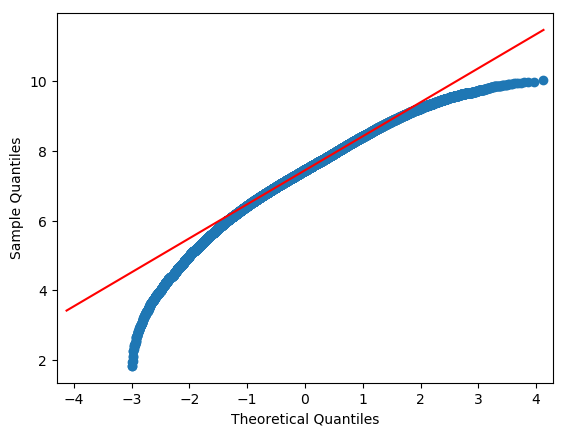

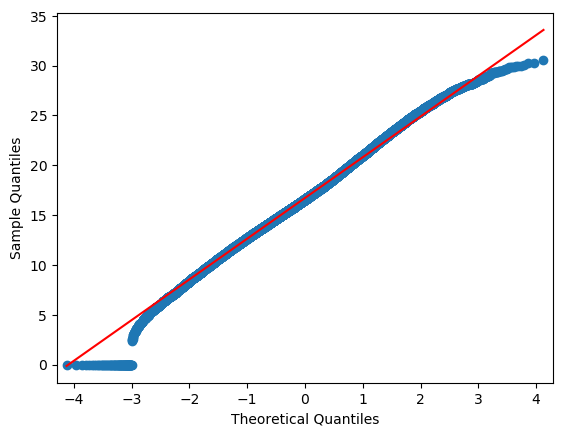

In [138]:
plots.plot_qq(dataframe=total_rec_log_transform ,
              column="log")
plots.plot_qq(dataframe=total_rec_YJ_transform,
              column="Yeo-Johnson")

The Yeo-Johnson transformation has the most effect on the data and therefore it will be used.

In [139]:
df_prep.dataframe["total_rec_int"] = total_rec_YJ_transform

In [ ]:
plots.hist_plot(dataframe= plots.dataframe,
                column="delinq_2yrs",
                title= "The number of 30+ days past-due payments in the borrower's credit file for the past 2 years",
                xlabel="Days",
                ylabel="Frequency")

The histogram show postive/right skew.

In [ ]:
delinq_log_transform = df_prep.skew_transform(df_prep.dataframe["delinq_2yrs"], transformation="log")
delinq_YJ_transform = df_prep.skew_transform(df_prep.dataframe["delinq_2yrs"], transformation="YJ")

plots.hist_plot(dataframe= delinq_log_transform,
                column="delinq_2yrs",
                title= "Log transform number of 30+ days past-due payments in the borrower's credit file for the past 2 years",
                xlabel="Days",
                ylabel="Frequency")

plots.hist_plot(dataframe= delinq_YJ_transform,
                column="Yeo-Johnson",
                title= "Yeo-Johnson transform number of 30+ days past-due payments in the borrower's credit file for the past 2 years",
                xlabel="Days",
                ylabel="Frequency")

c:\Users\ChAre\miniconda3\envs\EDA_finance_env\lib\site-packages\statsmodels\graphics\gofplots.py:915: RuntimeWarning: invalid value encountered in scalar subtract
  m = (q75 - q25) / np.diff(theoretical_quartiles)


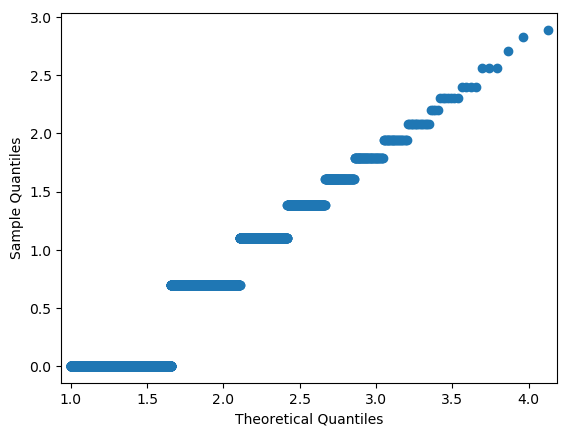

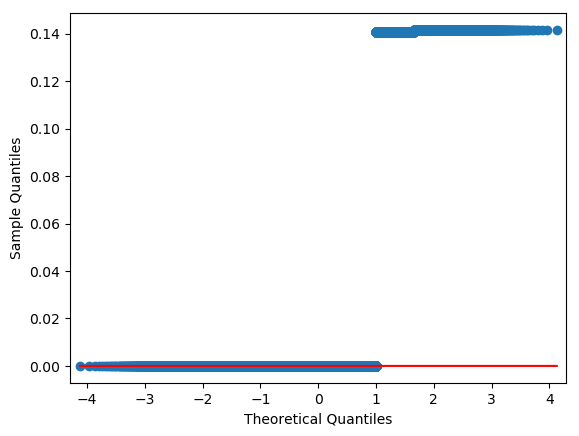

In [132]:
plots.plot_qq(dataframe=delinq_log_transform,
              column="log")
plots.plot_qq(dataframe=delinq_YJ_transform ,
              column="Yeo-Johnson")

In [133]:
df_prep.dataframe["delinq_2yrs"]  = delinq_log_transform 

In [ ]:
plots.hist_plot(dataframe= plots.dataframe,
                column="out_prncp",
                title= "Remaining outstanding principal for total amount funded",
                xlabel="Amount in pounds",
                ylabel="Frequency")

The histogram shows positive/right skew.

In [ ]:
# Apply log transformation.
out_pr_in_log_transform = df_prep.skew_transform(df_prep.dataframe["out_prncp"], transformation="log")
out_pr_YJ_transform = df_prep.skew_transform(df_prep.dataframe["out_prncp"], transformation="YJ")

# Plot log transformation
plots.hist_plot(dataframe= out_pr_in_log_transform,
                column="log",
                title= "Log transformed remaining outstanding principal for total amount funded",
                xlabel="Amount in pounds",
                ylabel="Frequency")

# Plot Box-Cox Yeo-Johnson
plots.hist_plot(dataframe = out_pr_YJ_transform,
                column="Yeo-Johnson",
                bins_size= 10, 
                title= "Yeo-Johnson transformed remaining outstanding principal for total amount funded", 
                xlabel="Amount in pounds",
                ylabel="Frequency")

In [ ]:
plots.plot_qq(dataframe=out_pr_in_log_transform,
              column="log")
plots.plot_qq(dataframe=out_pr_YJ_transform,
              column="Yeo-Johnson")

Histograms and qq plots showed that the transformation do not have great affect in normalising the data. Since the log transformation is the closet to normal distribution between the I will proceed wiht this transformation. However, this data  will require another transformation that brings the data closer to a normal distirbution.

In [ ]:
df_prep.dataframe["out_prncp"] = out_pr_in_log_transform


In [ ]:
plots.hist_plot(dataframe= plots.dataframe,
                column="out_prncp_inv",
                title= "Remaining outstanding principal for portion of total amount funded by investors",
                xlabel="Amount in pounds",
                ylabel="Frequency")

This histogram showed positve right skew.

In [ ]:
# Apply log transformation.
out_in_in_log_transform = df_prep.skew_transform(df_prep.dataframe["out_prncp_inv"], transformation="log")
out_in_YJ_transform = df_prep.skew_transform(df_prep.dataframe["out_prncp_inv"], transformation="YJ")

# Log transformation
plots.hist_plot(dataframe= out_in_in_log_transform,
                column="log",
                title= "Remaining outstanding principal for portion of total amount funded by investors",
                xlabel="Amount in pounds",
                ylabel="Frequency")

# Log transformation
plots.hist_plot(dataframe= out_in_YJ_transform,
                column="Yeo-Johnson",
                title= "Remaining outstanding principal for portion of total amount funded by investors",
                xlabel="Amount in pounds",
                ylabel="Frequency")

In [ ]:
plots.plot_qq(dataframe=out_in_in_log_transform,
              column="log")
plots.plot_qq(dataframe=out_in_YJ_transform,
              column="Yeo-Johnson")

The histograms and qq plots showed that either transformation cannot fully correct the skew of the data. However, since the distribution of the log transform data is closer to a normal distribtuion than the Yeo-Johnson, this one will be use for this data.

In [ ]:
df_prep.dataframe["out_prncp_inv"] = out_in_in_log_transform 

In [ ]:
plots.hist_plot(dataframe= plots.dataframe,
                column="recoveries",
                title= "Post charge off gross recovery",
                xlabel="Amount in pounds",
                ylabel="Frequency")

The histogram shows, positive/ rigth skew.

In [ ]:
# Apply log transformation.
recover_in_log_transform = df_prep.skew_transform(df_prep.dataframe["recoveries"], transformation="log")
recover_YJ_transform = df_prep.skew_transform(df_prep.dataframe["recoveries"], transformation="YJ")

# Log transformation
plots.hist_plot(dataframe= recover_in_log_transform,
                column="log",
                title= "Log transformed post charge off gross recovery",
                xlabel="Amount in pounds",
                ylabel="Frequency")

# Log transformation
plots.hist_plot(dataframe= recover_YJ_transform,
                column="Yeo-Johnson",
                title= " Yeo-Johnson transformed post charge off gross recovery",
                xlabel="Amount in pounds",
                ylabel="Frequency")

In [ ]:
plots.plot_qq(dataframe=recover_in_log_transform,
              column="log")
plots.plot_qq(dataframe=recover_YJ_transform,
              column="Yeo-Johnson")

The histograms and qq plots showed that either transformation cannot fully correct the skew of the data. However, since the distribution of the log transform data is closer to a normal distribtuion than the Yeo-Johnson, this one will be use for this data.

In [ ]:
df_prep.dataframe["recoveries"] = recover_in_log_transform

In [ ]:
plots.hist_plot(dataframe= plots.dataframe,
                column="collection_recovery_fee", 
                title= "Post charge off collection fee",
                xlabel="Amount in pounds",
                ylabel="Frequency",
                bins_size=5)

In [ ]:
# Apply log transformation.
collection_in_log_transform = df_prep.skew_transform(df_prep.dataframe["collection_recovery_fee"], transformation="log")
collection_YJ_transform = df_prep.skew_transform(df_prep.dataframe["collection_recovery_fee"], transformation="YJ")

# Plot log transformation
plots.hist_plot(dataframe= collection_in_log_transform,
                column="log", 
                title= "Log transform post charge off collection fee",
                xlabel="Amount in pounds",
                ylabel="Frequency",
                bins_size=5)

# Plot Box-Cox transformation
plots.hist_plot(dataframe = collection_YJ_transform,
                column="Yeo-Johnson",
                title= "Yeo-Johnson transformed post charge off collection fee",
                xlabel="Amount in pounds",
                ylabel="Frequency")

In [ ]:
plots.plot_qq(dataframe=collection_in_log_transform,
              column="log")
plots.plot_qq(dataframe=collection_YJ_transform,
              column="Yeo-Johnson")

The histograms and qqplots showed that the log transformation has the greates effect in correcting the skenes and therefore it will be used.

In [ ]:
df_prep.dataframe["collection_recovery_fee"] = collection_in_log_transform 

In [ ]:
plots.hist_plot(dataframe= plots.dataframe,
                column="total_rec_late_fee",
                title= "Late fees received to date",
                xlabel="Amount in pounds",
                ylabel="Frequency")

In [ ]:
# Apply log transformation.
total_p_in_log_transform = df_prep.skew_transform(df_prep.dataframe["total_rec_late_fee"], transformation="log")
total_p_YJ_transform = df_prep.skew_transform(df_prep.dataframe["total_rec_late_fee"], transformation="YJ")

plots.hist_plot(dataframe= total_p_in_log_transform,
                column="log",
                title= "Log transformed late fees received to date",
                xlabel="Amount in pounds",
                ylabel="Frequency")

plots.hist_plot(dataframe= total_p_YJ_transform,
                column="Yeo-Johnson",
                title= "Yeo-Johnson transformed late fees received to date",
                xlabel="Amount in pounds",
                ylabel="Frequency")

In [ ]:
plots.plot_qq(dataframe=total_p_in_log_transform,
              column="log")
plots.plot_qq(dataframe=total_p_YJ_transform,
              column="Yeo-Johnson")

The histograms and qqplots showed that the log transformation has the greates effect in correcting the skenes and therefore it will be used.

In [ ]:
df_prep.dataframe["total_rec_late_fee"] = total_p_in_log_transform

In [ ]:
plots.hist_plot(dataframe= plots.dataframe,
                column="inq_last_6mths",
                title= "The number of inquiries in past 6 months (excluding auto and mortgage inquiries)",
                xlabel="Inquiries",
                ylabel="Frequency")

This histogram showed positive/right skew.

In [ ]:
# Apply log transformation.
inq_last_in_log_transform = df_prep.skew_transform(df_prep.dataframe["inq_last_6mths"], transformation="log")
inq_last_YJ_transform = df_prep.skew_transform(df_prep.dataframe["inq_last_6mths"], transformation="YJ")

# Plot log transformation
plots.hist_plot(dataframe = inq_last_in_log_transform ,
                column="log",
                title= "Log transformed number of inquiries in past 6 months (excluding auto and mortgage inquiries)",
                xlabel="inquiries",
                ylabel="Frequency")



# Plot Box-Cox transformation
plots.hist_plot(dataframe = inq_last_YJ_transform,
                column="Yeo-Johnson",
                title= "Yeo-Johnson transformed number of inquiries in past 6 months (excluding auto and mortgage inquiries)",
                xlabel="inquiries",
                ylabel="Frequency")

In [ ]:
plots.plot_qq(dataframe=inq_last_in_log_transform,
              column="log")
plots.plot_qq(inq_last_YJ_transform,
              column="Yeo-Johnson")

The histograms and qqplots showed that the log transformation has the greates effect in correcting the skenes and therefore it will be used.

In [ ]:
df_prep.dataframe["inq_last_6mths"] = inq_last_in_log_transform

In [ ]:
plots.hist_plot(dataframe= plots.dataframe,
                column="open_accounts",
                title= "The number of open credit lines in the borrower's credit file",
                xlabel="Open accounts",
                ylabel="Frequency")

In [ ]:
# Apply log transformation.
open_a_in_log_transform = df_prep.skew_transform(df_prep.dataframe["open_accounts"], transformation="log")
open_a_BC_transform = df_prep.skew_transform(df_prep.dataframe["open_accounts"], transformation="BC")
open_a_YJ_transform = df_prep.skew_transform(df_prep.dataframe["open_accounts"], transformation="YJ")

# Log transformation
plots.hist_plot(dataframe= open_a_in_log_transform,
                column="log",
                title= "Log transformed number of open credit lines in the borrower's credit file",
                xlabel="Open accounts",
                ylabel="Frequency")


# Box-Cox transformation
plots.hist_plot(dataframe=open_a_BC_transform,
                column="Box-Cox",
                title= "Box-Cox transformed number of open credit lines in the borrower's credit file",
                xlabel="Open accounts",
                ylabel="Frequency")

# Plot Box-Cox transformation
plots.hist_plot(dataframe = open_a_YJ_transform,
                column="Yeo-Johnson",
                title= "Yeo-Johnson transformed number of open credit lines in the borrower's credit file",
                xlabel="Amount in pounds",
                ylabel="Frequency")

In [ ]:
plots.plot_qq(dataframe=open_a_in_log_transform,
              column="log")
plots.plot_qq(dataframe=open_a_BC_transform,
              column="Box-Cox")
plots.plot_qq(dataframe=open_a_YJ_transform,
              column="Yeo-Johnson")

The histograms and qqplots showed that the Box-Cox transformation had has the greates effect in bringign the distribution closer to normal. Although the the difference is not much greater than the effect of Yeo-Johnson transformation. Therefore the Box-Cox transformation will be used.

In [ ]:
df_prep.dataframe["total_payment"] = open_a_BC_transform


In [ ]:
plots.hist_plot(dataframe= plots.dataframe,
                column="total_accounts",
                title= "The total number of credit lines currently in the borrower's credit file",
                xlabel="Number of accounts",
                ylabel="Frequency")

Positive/right skew

In [ ]:
total_ac_in_log_transform = df_prep.skew_transform(df_prep.dataframe["total_accounts"], transformation="log")
total_ac_BC_transform = df_prep.skew_transform(df_prep.dataframe["total_accounts"], transformation="BC")
total_ac_YJ_transform = df_prep.skew_transform(df_prep.dataframe["total_accounts"], transformation="YJ")

plots.hist_plot(dataframe= total_ac_in_log_transform,
                column="log",
                title= "Log transformed total number of credit lines currently in the borrower's credit file",
                xlabel="Number of accounts",
                ylabel="Frequency")

plots.hist_plot(dataframe= total_ac_BC_transform,
                column="Box-Cox",
                title= "Box-Cox transformed total number of credit lines currently in the borrower's credit file",
                xlabel="Number of accounts",
                ylabel="Frequency")

plots.hist_plot(dataframe= total_ac_YJ_transform,
                column="Yeo-Johnson",
                title= "Yeo-Johnson transformed total number of credit lines currently in the borrower's credit file",
                xlabel="Number of accounts",
                ylabel="Frequency")



In [ ]:
plots.plot_qq(dataframe=total_ac_in_log_transform,
              column="log")
plots.plot_qq(dataframe=total_ac_BC_transform,
              column="Box-Cox")
plots.plot_qq(dataframe=total_ac_YJ_transform,
              column="Yeo-Johnson")

The histograms and qq plots shows that the box-Cox and Yeo-Johnson have the greates effect on the data. Since the data originally did not have any zero or negative values, the Box-Cox transformation will be used.

In [131]:
df_prep.dataframe["total_accounts"] = total_ac_BC_transform 

0        7.042222
1        7.599236
2        5.580006
3        4.571754
4        9.792344
           ...   
54226    2.991485
54227    2.657073
54228    5.580006
54229    0.802928
54230    4.571754
Name: total_accounts, Length: 54231, dtype: float64

In [ ]:
plots.hist_plot(dataframe= plots.dataframe,
                column="last_payment_amount",
                title= "Last total payment amount received",
                xlabel="Amount in pounds",
                ylabel="Frequency")


The histogram shows positive/right skew.

In [ ]:
# Apply transformations
last_p_in_log_transform = df_prep.skew_transform(df_prep.dataframe["last_payment_amount"], transformation="log")
last_p_YJ_transform = df_prep.skew_transform(df_prep.dataframe["last_payment_amount"], transformation="YJ")


plots.hist_plot(dataframe= last_p_in_log_transform,
                column="log",
                title= "Log trasnformed last total payment amount received",
                xlabel="Amount in pounds",
                ylabel="Frequency")

plots.hist_plot(dataframe= last_p_YJ_transform,
                column="Yeo-Johnson",
                title= "Yeo-Johnson trasnformed last total payment amount received",
                xlabel="Amount in pounds",
                ylabel="Frequency")

In [ ]:
plots.plot_qq(dataframe=last_p_in_log_transform,
              column="log")
plots.plot_qq(dataframe=last_p_YJ_transform,
              column="Yeo-Johnson")

The histograms and qq plots show that the Yeo-Johnson transformation ahs the greates effect. Therefore it will be applied to the data.

In [ ]:
df_prep.dataframe["last_payment_amount"] = last_p_YJ_transform

In [ ]:
plots.hist_plot(dataframe= plots.dataframe,
                column="collections_12_mths_ex_med",
                title= "Number of collections in 12 months' excluding medical collections",
                xlabel="Collections",
                ylabel="Frequency")

In [ ]:
# Apply log transformation.
collections_log_transform = df_prep.skew_transform(df_prep.dataframe["collections_12_mths_ex_med"], transformation="log")
collections_YJ_transform = df_prep.skew_transform(df_prep.dataframe["collections_12_mths_ex_med"], transformation="YJ")

plots.hist_plot(dataframe= collections_log_transform,
                column="log",
                title= " Log transformed number of collections in 12 months' excluding medical collections",
                xlabel="Collections",
                ylabel="Frequency")

plots.hist_plot(dataframe= collections_YJ_transform,
                column="Yeo-Johnson",
                title= "Log transformed number of collections in 12 months' excluding medical collections",
                xlabel="Collections",
                ylabel="Frequency")

In [ ]:
plots.plot_qq(dataframe=collections_log_transform,
              column="log")
plots.plot_qq(dataframe=collections_YJ_transform,
              column="Yeo-Johnson")

The histograms and qq plots show that the log transformation has the greates effect. Therefore it will be use to transform the data.

In [ ]:
df_prep.dataframe["collections_12_mths_ex_med"] = collections_log_transform

plt.figure(figsize=(10, 6))
sns.histplot(data=df_prep.dataframe, x="loan_amount", bins= 10)
plt.title('Distribution of log transformed amount of loan the applicant received')
plt.xlabel('log amount in pounds')
plt.ylabel('Frequency')
plt.grid(True, axis="y")
plt.show()